In [4]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline
import pandas as pd
import urllib
import cartopy.crs as ccrs
import os
import datetime
from matplotlib import ticker
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
from scipy.stats import t
GeoAxes._pcolormesh_patched = Axes.pcolormesh
from numpy import genfromtxt

In [5]:
def remove_time_mean(x):
    return x - x.mean(dim='time')

## Create clean OMI index

In [11]:
import os
os.chdir('/home/ivanov/matlab/Code/MJO_TW')

# Open OMI_index document and convert to a matrix
from numpy import genfromtxt
OMI_ind = genfromtxt('OMI_Index.txt', dtype = float)
OMI_amp = OMI_ind[:,6]

# Convert to polar coordinates
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

[rho, phi] = cart2pol(OMI_ind[:,5], -OMI_ind[:,4])

# Determine MJO phase
angles = np.arange(-np.pi, 5*np.pi/4,np.pi/4)
amp_std = np.std(OMI_amp)
OMI_phase = 0*phi

for i in range(len(phi)):
    if OMI_amp[i] >= amp_std:
        if (phi[i] >= angles[0] and phi[i] < angles[1]):
            OMI_phase[i] = 1
        elif (phi[i] >= angles[1] and phi[i] < angles[2]):
            OMI_phase[i] = 2
        elif (phi[i] >= angles[2] and phi[i] < angles[3]):
            OMI_phase[i] = 3
        elif (phi[i] >= angles[3] and phi[i] < angles[4]):
            OMI_phase[i] = 4
        elif (phi[i] >= angles[4] and phi[i] < angles[5]):
            OMI_phase[i] = 5
        elif (phi[i] >= angles[5] and phi[i] < angles[6]):
            OMI_phase[i] = 6
        elif (phi[i] >= angles[6] and phi[i] < angles[7]):
            OMI_phase[i] = 7
        else:
            OMI_phase[i] = 8
    else:
        OMI_phase[i] = 0

In [4]:
# Create datetime array
start = datetime.datetime.strptime("01-01-1979", "%d-%m-%Y")
end = datetime.datetime.strptime("08-02-2020", "%d-%m-%Y")
dates = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]

# Create data arrays for amplitude and phase (OMI index)
OMIamp_DA = xr.DataArray(OMI_amp, coords=[dates], dims=["time"])
OMIamp_DS = xr.Dataset({"OMIamp": OMIamp_DA})

OMIphase_DA = xr.DataArray(OMI_phase, coords=[dates], dims=["time"])
OMIphase_DS = xr.Dataset({"OMIphase": OMIphase_DA})

# Data Processing and Saving

## OLR

In [5]:
# Load OLR data
mtnlwrf_data = xr.open_mfdataset('/dx01/data/ERA5/top_net_longwave_radiation_dailymean/*.nc', parallel = True, combine = 'by_coords')

In [6]:
OLR_data = -1*mtnlwrf_data

# Calculate OLR anomalies
OLR_anom = OLR_data.groupby('time.month').apply(remove_time_mean)

# Add OMI amplitude and phase variables to OLR dataset
OLR_anom_OMI = xr.merge([OLR_anom,OMIamp_DS,OMIphase_DS], join='inner')

# Remove outliers
OLR_real_OMI = OLR_anom_OMI.sel(time = OLR_anom_OMI['OMIamp'] < 5)

# Only select active MJO
#OMI_amp_std = np.std(OMI_amp)
#OLR_active_OMI = OLR_real_OMI.sel(time = OLR_real_OMI['OMIamp'] > OMI_amp_std)

In [7]:
# Group by season
MJ_OLRdata = OLR_real_OMI.where(OLR_real_OMI.time.dt.month.isin([5, 6]), drop=True)
JA_OLRdata = OLR_real_OMI.where(OLR_real_OMI.time.dt.month.isin([7, 8]), drop=True)

# Regional data
MJ_OLR_reg = MJ_OLRdata.sel(longitude = slice(40,100), latitude = slice(35,0))
JA_OLR_reg = JA_OLRdata.sel(longitude = slice(40,100), latitude = slice(35,0))

# Calculate average OLR anomaly in each phase, seasonally
MJ_OLR_OMI = MJ_OLR_reg.groupby(MJ_OLR_reg.OMIphase).mean()
JA_OLR_OMI = JA_OLR_reg.groupby(JA_OLR_reg.OMIphase).mean()

In [1]:
# Save to netcdf
MJ_OLR_OMI.to_netcdf("/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_OLR.nc")
JA_OLR_OMI.to_netcdf("/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_OLR.nc")

## Temperature

In [18]:
# 2m air temperature
temp_data = xr.open_mfdataset('/dx01/data/ERA5/2mtemp_dailymean/*.nc', parallel = True, combine = 'by_coords', chunks = {'time':400})
temp_C = temp_data - 273.15 #convert from kelvin

temp_anom = temp_C.groupby('time.month').apply(remove_time_mean)

# Add amplitude and phase columns to temperature dataset
temp_anom = xr.merge([temp_anom,OMIamp_DS,OMIphase_DS], join= 'inner')

# Remove outliers
temp_real = temp_anom.sel(time = temp_anom['OMIamp'] < 5)

# Only select active MJO, group by season, and select regional data
#amp_std = np.std(OMIamp_DS.OMIamp)
MJ_T_data = temp_real.sel(longitude = slice(40,100), latitude = slice(35,0)).where(temp_real.time.dt.month.isin([5, 6]), drop=True)
JA_T_data = temp_real.sel(longitude = slice(40,100), latitude = slice(35,0)).where(temp_real.time.dt.month.isin([7, 8]), drop=True)

# Calculate average OLR anomaly in each phase, seasonally
MJ_T_OMI = MJ_T_data.groupby(MJ_T_data.OMIphase).mean()
JA_T_OMI = JA_T_data.groupby(JA_T_data.OMIphase).mean()

In [22]:
# Save temperature data by OMI to netcdf
MJ_T_OMI.to_netcdf("/dx01/ivanov/data/ERA5/MJ_regional_temp.nc")
JA_T_OMI.to_netcdf("/dx01/ivanov/data/ERA5/JA_regional_temp.nc")

In [23]:
# Compute regional temperature climatology and save to netcdf
temp_MJ_clim = temp_C.sel(longitude = slice(40,100), latitude = slice(35,0)).where(temp_C.time.dt.month.isin([5, 6]), drop=True).mean(dim = 'time')
temp_MJ_clim.to_netcdf("/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_temp_clim.nc")

temp_JA_clim = temp_C.sel(longitude = slice(40,100), latitude = slice(35,0)).where(temp_C.time.dt.month.isin([7, 8]), drop=True).mean(dim = 'time')
temp_JA_clim.to_netcdf("/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_temp_clim.nc")

## Winds

In [24]:
# U-winds
u_wind = xr.open_mfdataset('/dx01/data/ERA5/uwind_10m_dailymean/*.nc', parallel = True, combine = 'by_coords')

# V-winds
v_wind = xr.open_mfdataset('/dx01/data/ERA5/vwind_10m_dailymean/*.nc', parallel = True, combine = 'by_coords')

# Calculate wind anomalies
uwind_anom = u_wind.groupby('time.month').apply(remove_time_mean)
vwind_anom = v_wind.groupby('time.month').apply(remove_time_mean)

# Add amplitude and phase columns to OLR dataset
uwind_anom = xr.merge([uwind_anom, OMIamp_DS, OMIphase_DS], join = 'inner')
vwind_anom = xr.merge([vwind_anom, OMIamp_DS, OMIphase_DS], join = 'inner')

# Total wind
uwind = xr.merge([u_wind, OMIamp_DS, OMIphase_DS], join = 'inner')
vwind = xr.merge([v_wind, OMIamp_DS, OMIphase_DS], join = 'inner')

In [25]:
# ANOMALIES
# Remove outliers
u_real = uwind_anom.sel(time = uwind_anom['OMIamp'] < 5)
v_real = vwind_anom.sel(time = vwind_anom['OMIamp'] < 5)

# Only select active MJO
#u_active = u_real.sel(time = u_real['OMIamp'] > amp_std)
#v_active = v_real.sel(time = v_real['OMIamp'] > amp_std)

# Group by season
MJ_udata = u_real.where(u_real.time.dt.month.isin([5, 6]), drop=True)
JA_udata = u_real.where(u_real.time.dt.month.isin([7, 8]), drop=True)

MJ_vdata = v_real.where(v_real.time.dt.month.isin([5, 6]), drop=True)
JA_vdata = v_real.where(v_real.time.dt.month.isin([7, 8]), drop=True)

# Calculate average uwind anomaly in each phase, seasonally
MJ_u = MJ_udata.groupby(MJ_udata.OMIphase).mean()
JA_u = JA_udata.groupby(JA_udata.OMIphase).mean()

MJ_v = MJ_vdata.groupby(MJ_vdata.OMIphase).mean()
JA_v = JA_vdata.groupby(JA_vdata.OMIphase).mean()

#Select regional data
MJ_u_reg = MJ_u.sel(longitude = slice(40,100), latitude = slice(35,0))
JA_u_reg = JA_u.sel(longitude = slice(40,100), latitude = slice(35,0))

MJ_v_reg = MJ_v.sel(longitude = slice(40,100), latitude = slice(35,0))
JA_v_reg = JA_v.sel(longitude = slice(40,100), latitude = slice(35,0))

In [26]:
# TOTAL WIND
u_real_total = uwind.sel(time = uwind['OMIamp'] < 5)
v_real_total = vwind.sel(time = vwind['OMIamp'] < 5)

# Only select active MJO
#u_active_total = u_real_total.sel(time = u_real_total['OMIamp'] > amp_std)
#v_active_total = v_real_total.sel(time = v_real_total['OMIamp'] > amp_std)

# Group by season
MJ_udata_total = u_real_total.where(u_real_total.time.dt.month.isin([5, 6]), drop=True)
JA_udata_total = u_real_total.where(u_real_total.time.dt.month.isin([7, 8]), drop=True)

MJ_vdata_total = v_real_total.where(v_real_total.time.dt.month.isin([5, 6]), drop=True)
JA_vdata_total = v_real_total.where(v_real_total.time.dt.month.isin([7, 8]), drop=True)

# Calculate average uwind anomaly in each phase, seasonally
MJ_u_total = MJ_udata_total.groupby(MJ_udata_total.OMIphase).mean()
JA_u_total = JA_udata_total.groupby(JA_udata_total.OMIphase).mean()

MJ_v_total = MJ_vdata_total.groupby(MJ_vdata_total.OMIphase).mean()
JA_v_total = JA_vdata_total.groupby(JA_vdata_total.OMIphase).mean()

#Select regional data
MJ_u_reg_total = MJ_u_total.sel(longitude = slice(40,100), latitude = slice(35,0))
JA_u_reg_total = JA_u_total.sel(longitude = slice(40,100), latitude = slice(35,0))

MJ_v_reg_total = MJ_v_total.sel(longitude = slice(40,100), latitude = slice(35,0))
JA_v_reg_total = JA_v_total.sel(longitude = slice(40,100), latitude = slice(35,0))

In [27]:
# Save to netcdf
MJ_u_reg.to_netcdf("/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_uwind.nc")
JA_u_reg.to_netcdf("/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_uwind.nc")

In [28]:
MJ_v_reg.to_netcdf("/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_vwind.nc")
JA_v_reg.to_netcdf("/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_vwind.nc")

In [29]:
# Calculate and save climatologies
uwind_MJ_clim = u_wind.sel(longitude = slice(40,100), latitude = slice(35,0)).where(u_wind.time.dt.month.isin([5, 6]), drop=True).mean(dim = 'time')
uwind_JA_clim = u_wind.sel(longitude = slice(40,100), latitude = slice(35,0)).where(u_wind.time.dt.month.isin([7, 8]), drop=True).mean(dim = 'time')

vwind_MJ_clim = v_wind.sel(longitude = slice(40,100), latitude = slice(35,0)).where(v_wind.time.dt.month.isin([5, 6]), drop=True).mean(dim = 'time')
vwind_JA_clim = v_wind.sel(longitude = slice(40,100), latitude = slice(35,0)).where(v_wind.time.dt.month.isin([7, 8]), drop=True).mean(dim = 'time')

In [30]:
uwind_MJ_clim.to_netcdf("/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_uwind_clim.nc")
uwind_JA_clim.to_netcdf("/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_uwind_clim.nc")

In [31]:
vwind_MJ_clim.to_netcdf("/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_vwind_clim.nc")
vwind_JA_clim.to_netcdf("/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_vwind_clim.nc")

## Water Vapor Flux

In [22]:
# E flux
e_vapor = xr.open_mfdataset('/dx01/data/ERA5/integrated_e_vapor_flux_dailymean/*.nc', parallel = True, combine = 'by_coords')

# N flux
n_vapor = xr.open_mfdataset('/dx01/data/ERA5/integrated_n_vapor_flux_dailymean/*.nc', parallel = True, combine = 'by_coords')

# Calculate flux anomalies
evapor_anom = e_vapor.groupby('time.month').apply(remove_time_mean)
nvapor_anom = n_vapor.groupby('time.month').apply(remove_time_mean)

# Add amplitude and phase columns to OLR dataset
evapor_anom = xr.merge([evapor_anom, OMIamp_DS, OMIphase_DS], join = 'inner')
nvapor_anom = xr.merge([nvapor_anom, OMIamp_DS, OMIphase_DS], join = 'inner')

# Total vapor
evapor = xr.merge([e_vapor, OMIamp_DS, OMIphase_DS], join = 'inner')
nvapor = xr.merge([n_vapor, OMIamp_DS, OMIphase_DS], join = 'inner')

# ANOMALIES
# Remove outliers
e_real = evapor_anom.sel(time = evapor_anom['OMIamp'] < 5)
n_real = nvapor_anom.sel(time = nvapor_anom['OMIamp'] < 5)

# Only select active MJO
#u_active = u_real.sel(time = u_real['OMIamp'] > amp_std)
#v_active = v_real.sel(time = v_real['OMIamp'] > amp_std)

# Group by season
MJ_edata = e_real.where(e_real.time.dt.month.isin([5, 6]), drop=True)
JA_edata = e_real.where(e_real.time.dt.month.isin([7, 8]), drop=True)

MJ_ndata = n_real.where(n_real.time.dt.month.isin([5, 6]), drop=True)
JA_ndata = n_real.where(n_real.time.dt.month.isin([7, 8]), drop=True)

# Calculate average uwind anomaly in each phase, seasonally
MJ_e = MJ_edata.groupby(MJ_edata.OMIphase).mean()
JA_e = JA_edata.groupby(JA_edata.OMIphase).mean()

MJ_n = MJ_ndata.groupby(MJ_ndata.OMIphase).mean()
JA_n = JA_ndata.groupby(JA_ndata.OMIphase).mean()

#Select regional data
MJ_e_reg = MJ_e.sel(longitude = slice(40,100), latitude = slice(35,0))
JA_e_reg = JA_e.sel(longitude = slice(40,100), latitude = slice(35,0))

MJ_n_reg = MJ_n.sel(longitude = slice(40,100), latitude = slice(35,0))
JA_n_reg = JA_n.sel(longitude = slice(40,100), latitude = slice(35,0))

# TOTAL VAPOR
e_real_total = evapor.sel(time = evapor['OMIamp'] < 5)
n_real_total = nvapor.sel(time = nvapor['OMIamp'] < 5)

# Only select active MJO
#u_active_total = u_real_total.sel(time = u_real_total['OMIamp'] > amp_std)
#v_active_total = v_real_total.sel(time = v_real_total['OMIamp'] > amp_std)

# Group by season
MJ_edata_total = e_real_total.where(e_real_total.time.dt.month.isin([5, 6]), drop=True)
JA_edata_total = e_real_total.where(e_real_total.time.dt.month.isin([7, 8]), drop=True)

MJ_ndata_total = n_real_total.where(n_real_total.time.dt.month.isin([5, 6]), drop=True)
JA_ndata_total = n_real_total.where(n_real_total.time.dt.month.isin([7, 8]), drop=True)

# Calculate average uwind anomaly in each phase, seasonally
MJ_e_total = MJ_edata_total.groupby(MJ_edata_total.OMIphase).mean()
JA_e_total = JA_edata_total.groupby(JA_edata_total.OMIphase).mean()

MJ_n_total = MJ_ndata_total.groupby(MJ_ndata_total.OMIphase).mean()
JA_n_total = JA_ndata_total.groupby(JA_ndata_total.OMIphase).mean()

#Select regional data
MJ_e_reg_total = MJ_e_total.sel(longitude = slice(40,100), latitude = slice(35,0))
JA_e_reg_total = JA_e_total.sel(longitude = slice(40,100), latitude = slice(35,0))

MJ_n_reg_total = MJ_n_total.sel(longitude = slice(40,100), latitude = slice(35,0))
JA_n_reg_total = JA_n_total.sel(longitude = slice(40,100), latitude = slice(35,0))

In [26]:
# Save to netcdf
MJ_e_reg.to_netcdf("/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_evapor.nc")
JA_e_reg.to_netcdf("/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_evapor.nc")

MJ_n_reg.to_netcdf("/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_nvapor.nc")
JA_n_reg.to_netcdf("/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_nvapor.nc")

In [27]:
# Calculate and save climatologies
evapor_MJ_clim = e_vapor.sel(longitude = slice(40,100), latitude = slice(35,0)).where(e_vapor.time.dt.month.isin([5, 6]), drop=True).mean(dim = 'time')
evapor_JA_clim = e_vapor.sel(longitude = slice(40,100), latitude = slice(35,0)).where(e_vapor.time.dt.month.isin([7, 8]), drop=True).mean(dim = 'time')

nvapor_MJ_clim = n_vapor.sel(longitude = slice(40,100), latitude = slice(35,0)).where(n_vapor.time.dt.month.isin([5, 6]), drop=True).mean(dim = 'time')
nvapor_JA_clim = n_vapor.sel(longitude = slice(40,100), latitude = slice(35,0)).where(n_vapor.time.dt.month.isin([7, 8]), drop=True).mean(dim = 'time')

evapor_MJ_clim.to_netcdf("/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_evapor_clim.nc")
evapor_JA_clim.to_netcdf("/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_evapor_clim.nc")

nvapor_MJ_clim.to_netcdf("/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_nvapor_clim.nc")
nvapor_JA_clim.to_netcdf("/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_nvapor_clim.nc")

## Specific Humidity

In [32]:
# Surface dewpoint
d2m_data = xr.open_mfdataset('/dx01/data/ERA5/2mdewpoint_dailymean/*.nc', parallel = True, combine = 'by_coords')
d2m_C = d2m_data.d2m - 273.15 #convert from kelvin

# Surface pressure
sp_data = xr.open_mfdataset('/dx01/data/ERA5/surface_pressure_dailymean/*.nc', parallel = True, combine = 'by_coords')
sp_mb = sp_data/100

# Specific humidity
vap_pres = 6.112*np.exp((17.67*d2m_C)/(d2m_C + 243.5))
q = (0.622 * vap_pres)/(sp_mb.sp - (0.378 * vap_pres))
q_derived = q.to_dataset(name = 'q')
q_derived

# Calculate specific humidity anomalies
q_anom_derived = q_derived.groupby('time.month').apply(remove_time_mean)

# Add to precip anom
q_anom_derived = xr.merge([q_anom_derived, OMIamp_DS, OMIphase_DS], join = 'inner')

In [33]:
# Remove outliers
q_real = q_anom_derived.sel(time = q_anom_derived['OMIamp'] < 5)

# Only select active MJO
#amp_std = np.std(OMIamp_DS.OMIamp)
#q_active = q_real.sel(time = q_anom_derived['OMIamp'] > amp_std)

# Group by season
MJ_qdata = q_real.where(q_real.time.dt.month.isin([5, 6]), drop=True)
JA_qdata = q_real.where(q_real.time.dt.month.isin([7, 8]), drop=True)

# Calculate average temperature anomaly in each phase, seasonally
MJ_q = MJ_qdata.groupby(MJ_qdata.OMIphase).mean()
JA_q = JA_qdata.groupby(JA_qdata.OMIphase).mean()

# Select regional data
MJ_q_reg = MJ_q.sel(longitude = slice(40,100), latitude = slice(35,0))
JA_q_reg = JA_q.sel(longitude = slice(40,100), latitude = slice(35,0))

In [36]:
# Save SH data by OMI to netcdf
MJ_q_reg.to_netcdf("/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_SH.nc")
JA_q_reg.to_netcdf("/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_SH.nc")

In [37]:
# Compute regional SH climatology and save to netcdf
SH_MJ_clim = q_derived.sel(longitude = slice(40,100), latitude = slice(35,0)).where(q_derived.time.dt.month.isin([5, 6]), drop=True).mean(dim = 'time')
SH_JA_clim = q_derived.sel(longitude = slice(40,100), latitude = slice(35,0)).where(q_derived.time.dt.month.isin([7, 8]), drop=True).mean(dim = 'time')

SH_MJ_clim.to_netcdf("/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_SH_clim.nc")
SH_JA_clim.to_netcdf("/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_SH_clim.nc")

## Wet Bulb

In [39]:
# Surface wet bulb
TW_data = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/submission1/regional_Tw_dailymean.nc')

# Calculate specific humidity anomalies
TW_anom = TW_data.groupby('time.month').apply(remove_time_mean)

# Add to precip anom
TW_anom = xr.merge([TW_anom, OMIamp_DS, OMIphase_DS], join = 'inner')

In [41]:
# Remove outliers
TW_real = TW_anom.sel(time = TW_anom['OMIamp'] < 5)

# Only select active MJO
#amp_std = np.std(OMIamp_DS.OMIamp)
#TW_active = TW_real.sel(time = TW_real['OMIamp'] > amp_std)

# Group by season
MJ_TWdata = TW_real.where(TW_real.time.dt.month.isin([5, 6]), drop=True)
JA_TWdata = TW_real.where(TW_real.time.dt.month.isin([7, 8]), drop=True)

# Calculate average temperature anomaly in each phase, seasonally
MJ_TW = MJ_TWdata.groupby(MJ_TWdata.OMIphase).mean()
JA_TW = JA_TWdata.groupby(JA_TWdata.OMIphase).mean()

# Select regional data
MJ_TW_reg = MJ_TW.sel(longitude = slice(40,100), latitude = slice(35,0))
JA_TW_reg = JA_TW.sel(longitude = slice(40,100), latitude = slice(35,0))

In [44]:
# Save Tw data by OMI to netcdf
MJ_TW_reg.to_netcdf("/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_TW.nc")
JA_TW_reg.to_netcdf("/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_TW.nc")

In [46]:
# Compute regional SH climatology and save to netcdf
TW_MJ_clim = TW_data.sel(longitude = slice(40,100), latitude = slice(35,0)).where(TW_data.time.dt.month.isin([5, 6]), drop=True).mean(dim = 'time')
TW_JA_clim = TW_data.sel(longitude = slice(40,100), latitude = slice(35,0)).where(TW_data.time.dt.month.isin([7, 8]), drop=True).mean(dim = 'time')

TW_MJ_clim.to_netcdf("/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_TW_clim.nc")
TW_JA_clim.to_netcdf("/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_TW_clim.nc")


# Composites

## OLR

### MAY-JUNE

In [6]:
# Load data
OLR = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_OLR.nc')

In [8]:
# Plot regional maps of OLR composites
fig, axs = plt.subplots(4,2, figsize=(11,18), facecolor='w', edgecolor='k', subplot_kw = {'projection': ccrs.PlateCarree()})
axs = axs.ravel()

plt.rcParams.update({'hatch.color': 'grey'})

# MJJA
levels = np.linspace(-25,25, 25)

x = OLR.longitude
y = OLR.latitude

for i in range(8):

    sig_mask = genfromtxt("MJ_OLR_phase" + np.str(i+1) + "_sigmask.csv", delimiter=',').astype(np.bool)

    unsig = ~np.array(sig_mask)
    unsig_plot = unsig.astype(int)

    [m,n] = np.where(unsig_plot > 0)

    z1=np.zeros(unsig_plot.shape)
    z1[m, n] = 99
    
    contf = axs[i].contourf(OLR.sel(OMIphase = i+1).longitude, OLR.sel(OMIphase = i+1).latitude, 
                           OLR.sel(OMIphase = i+1).mtnlwrf, levels = levels, cmap = 'BrBG_r', extend = 'both', zorder = 1)
    axs[i].coastlines()
    phase_label = axs[i].text(0.982,0.92,'Phase ' + str(i+1), horizontalalignment = 'right',transform = axs[i].transAxes, fontweight = 600)
    phase_label.set_bbox(dict(facecolor='white', edgecolor = 'white'))
    axs[i].set_yticks([0, 10, 20, 30], crs=ccrs.PlateCarree())
    axs[i].set_xticks([40, 60, 80, 100], crs=ccrs.PlateCarree())
    
    cs = axs[i].contourf(x, y, z1, 3, hatches=['', '..'], color = 'grey',linestyles = None, alpha = 0)
    
    if (i % 2) == 0:
        axs[i].set_ylabel('Latitude')  
    
    if (i == 6) or (i == 7):
        axs[i].set_xlabel('Longitude')
    
    

cbar = plt.colorbar(contf, ax=axs.ravel().tolist(), shrink = 0.5, location = 'bottom', pad = 0.05)
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label('OLR Anomaly ($\mathregular{W/m^2}$)')
plt.show()

### JULY-AUGUST

In [7]:
# Load data
OLR = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_OLR.nc')

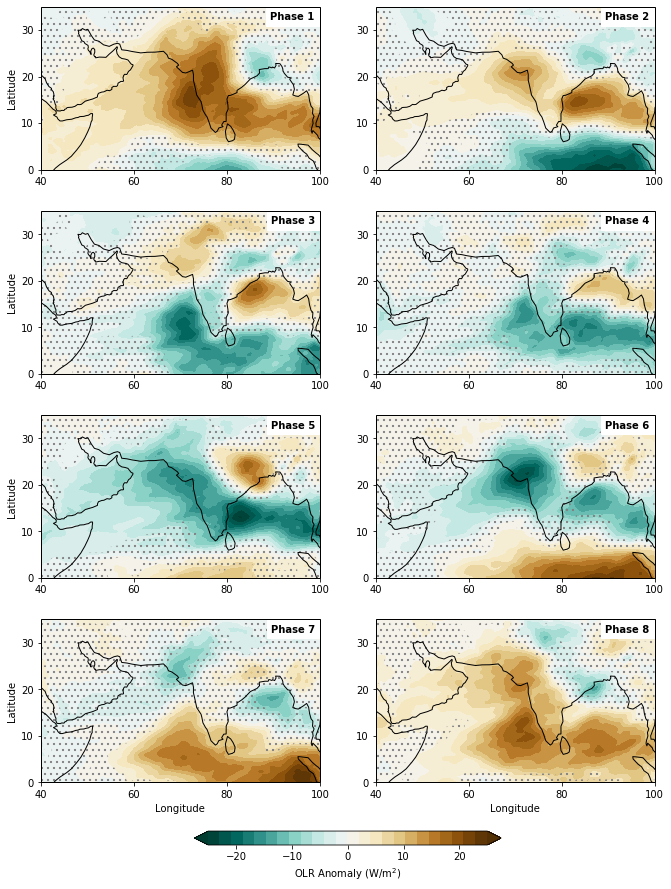

In [8]:
# Plot regional maps of OLR composites
fig, axs = plt.subplots(4,2, figsize=(11,18), facecolor='w', edgecolor='k', subplot_kw = {'projection': ccrs.PlateCarree()})
axs = axs.ravel()

# MJJA
levels = np.linspace(-25,25, 25)

for i in range(8):
    
    sig_mask = genfromtxt("JA_OLR_phase" + np.str(i+1) + "_sigmask.csv", delimiter=',').astype(np.bool)

    unsig = ~np.array(sig_mask)
    unsig_plot = unsig.astype(int)

    [m,n] = np.where(unsig_plot > 0)

    z1=np.zeros(unsig_plot.shape)
    z1[m, n] = 99
    
    
    contf = axs[i].contourf(OLR.sel(OMIphase = i+1).longitude, OLR.sel(OMIphase = i+1).latitude, 
                           OLR.sel(OMIphase = i+1).mtnlwrf, levels = levels, cmap = 'BrBG_r', extend = 'both', zorder = 1)
    axs[i].coastlines()
    phase_label = axs[i].text(0.982,0.92,'Phase ' + str(i+1), horizontalalignment = 'right',transform = axs[i].transAxes, fontweight = 600)
    phase_label.set_bbox(dict(facecolor='white', edgecolor = 'white'))
    axs[i].set_yticks([0, 10, 20, 30], crs=ccrs.PlateCarree())
    axs[i].set_xticks([40, 60, 80, 100], crs=ccrs.PlateCarree())
    
    cs = axs[i].contourf(x, y, z1, 3, hatches=['', '..'], color = 'grey',linestyles = None, alpha = 0)
    
    if (i % 2) == 0:
        axs[i].set_ylabel('Latitude')  
    
    if (i == 6) or (i == 7):
        axs[i].set_xlabel('Longitude')

cbar = plt.colorbar(contf, ax=axs.ravel().tolist(), shrink = 0.5, location = 'bottom', pad = 0.05)
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label('OLR Anomaly ($\mathregular{W/m^2}$)')
plt.show()

## Temperature

### MAY-JUNE

In [9]:
# Load data
temp = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_temp.nc')
uwind = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_uwind.nc')
vwind = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_vwind.nc')

temp_clim = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_temp_clim.nc')
uwind_clim = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_uwind_clim.nc')
vwind_clim = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_vwind_clim.nc')

OLR = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_OLR.nc')

In [7]:
CME_lat = [20, 36]
CME_lon = [45, 60]

NW_lat = [22, 32]
NW_lon = [68, 78]

SE_lat = [8, 22]
SE_lon = [78, 90]

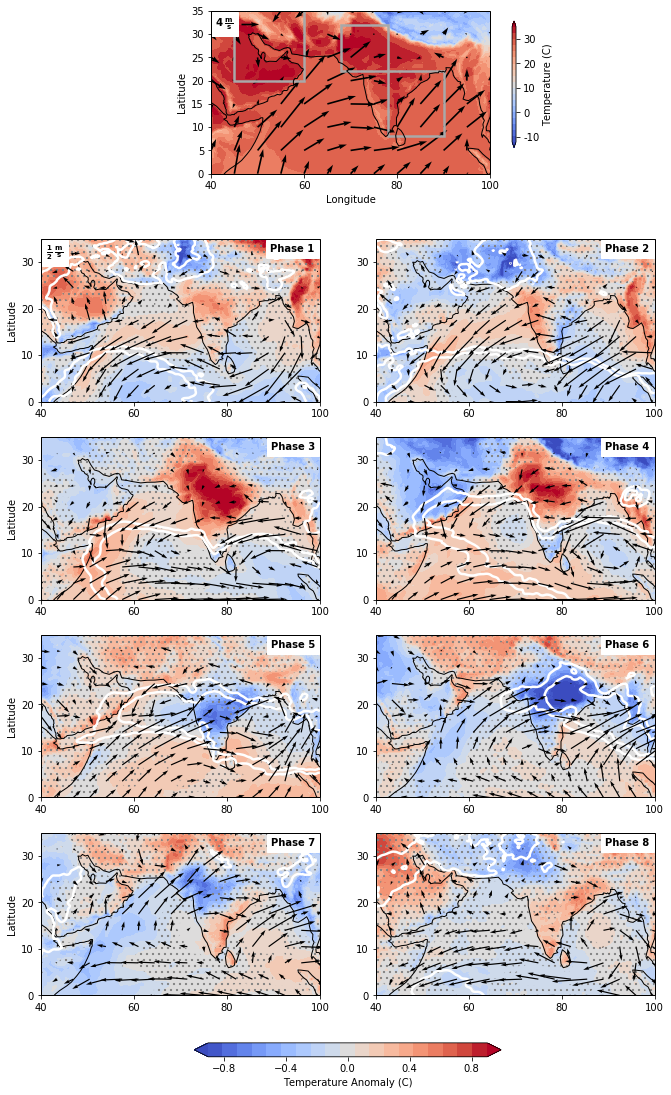

In [53]:
# Plot regional climatology
n = 20
skip = (slice(None, None, n), slice(None, None, n))

fig, axs = plt.subplots(5,2, figsize=(11,22), facecolor='w', edgecolor='k', subplot_kw = {'projection': ccrs.PlateCarree()})
sub_axs = axs[1:5,:].ravel()

clim_levels = np.linspace(-12,35, 20)

temp_map = axs[0,0].contourf(temp_clim.longitude, temp_clim.latitude, temp_clim.t2m, levels = clim_levels, cmap = 'coolwarm',  extend = 'both')
winds = axs[0,0].quiver(uwind_clim.longitude[::n], uwind_clim.latitude[::n], uwind_clim.u10[skip], vwind_clim.v10[skip])
qk = axs[0,0].quiverkey(winds, 0.108, 0.92, 4, r'$\mathbf{4 \: \frac{m}{s}}$',labelpos='W', coordinates='axes', color='k', labelcolor='k', fontproperties = {"weight": "bold"})
box = qk.text.set_backgroundcolor('w')

axs[0,0].set_ylabel('Latitude')
axs[0,0].set_xlabel('Longitude')
axs[0,0].coastlines(resolution = '110m')
axs[0,0].set_xticks([40, 60, 80, 100], crs=ccrs.PlateCarree())
axs[0,0].set_yticks([0, 5, 10, 15, 20, 25, 30, 35], crs=ccrs.PlateCarree())

# Add boxes for subregions
p1 = plt.Rectangle((CME_lon[0], CME_lat[0]), CME_lon[1]-CME_lon[0], CME_lat[1]-CME_lat[0], fill=False, linewidth = 2.5, color = 'darkgrey')
p2 = plt.Rectangle((NW_lon[0], NW_lat[0]), NW_lon[1]-NW_lon[0], NW_lat[1]-NW_lat[0], fill=False, linewidth = 2.5, color = 'darkgrey')
p3 = plt.Rectangle((SE_lon[0], SE_lat[0]), SE_lon[1]-SE_lon[0], SE_lat[1]-SE_lat[0], fill=False, linewidth = 2.5, color = 'darkgrey')
axs[0,0].add_patch(p1)
axs[0,0].add_patch(p2)
axs[0,0].add_patch(p3)

cax = fig.add_axes([0.72, 0.78, 0.005, 0.08])
colorb = fig.colorbar(temp_map, cax = cax, shrink = 0.5, format = "%d", label = 'Temperature (C)')
tick_locator = ticker.MaxNLocator(nbins=5)
colorb.locator = tick_locator
colorb.update_ticks()

fig.delaxes(axs[0,1])

# Move subplot 1 and colorbar to center
box = axs[0,0].get_position()
box.x0 = box.x0 + 0.215
box.x1 = box.x1 + 0.215
axs[0,0].set_position(box)

# Plot regional maps of temperature anomalies

# MJJA
n = 14
skip = (slice(None, None, n), slice(None, None, n))

levels = np.linspace(-0.9,0.9, 20)
clevels = np.arange(-8, 0, 4)
plt.rcParams['contour.negative_linestyle'] = 'solid'

x = temp.longitude
y = temp.latitude

plt.rcParams.update({'hatch.color': 'grey'})

for i in range(8):
    
    sig_mask = genfromtxt("MJ_T_phase" + np.str(i+1) + "_sigmask.csv", delimiter=',').astype(np.bool)

    unsig = ~np.array(sig_mask)
    unsig_plot = unsig.astype(int)

    [m,n] = np.where(unsig_plot > 0)

    z1=np.zeros(unsig_plot.shape)
    z1[m, n] = 99
    
    u = uwind.sel(OMIphase = i+1)
    u1 = u.u10

    v = vwind.sel(OMIphase = i+1)
    v1 = v.v10

    #lat = u1.latitude
    #lon = v1.longitude
    
    #lat_sub = lat[::n]
    #lon_sub = lon[::n]

    u_sub = u1[skip]
    v_sub = v1[skip]
    
    contf = sub_axs[i].contourf(temp.sel(OMIphase = i+1).longitude, temp.sel(OMIphase = i+1).latitude, 
                           temp.sel(OMIphase = i+1).t2m, levels = levels, cmap = 'coolwarm', extend = 'both', zorder = 1)
    cont = sub_axs[i].contour(OLR.sel(OMIphase = i+1).longitude, OLR.sel(OMIphase = i+1).latitude, OLR.sel(OMIphase = i+1).mtnlwrf, clevels, colors ='white', extend='both', linewidths = 2.5, zorder = 2)
    q = sub_axs[i].quiver(uwind_clim.longitude[::14], uwind_clim.latitude[::14], u_sub, v_sub, zorder = 3)
    sub_axs[i].coastlines()
    phase_label = sub_axs[i].text(0.982,0.92,'Phase ' + str(i+1), horizontalalignment = 'right',transform = sub_axs[i].transAxes, fontweight = 600)
    phase_label.set_bbox(dict(facecolor='white', edgecolor = 'white'))
    sub_axs[i].set_yticks([0, 10, 20, 30], crs=ccrs.PlateCarree())
    sub_axs[i].set_xticks([40, 60, 80, 100], crs=ccrs.PlateCarree())
    
    cs = sub_axs[i].contourf(x, y, z1, 3, hatches=['', '..'], colors = 'grey',linestyles = None, alpha = 0)
    
    if (i % 2) == 0:
        sub_axs[i].set_ylabel('Latitude')  
    
    if (i == 8) or (i == 9):
        sub_axs[i].set_xlabel('Longitude')
        
    if i == 0:
        qk = sub_axs[0].quiverkey(q, 0.108, 0.915, 0.5, r'$\mathbf{\frac{1}{2} \: \frac{m}{s}}$',labelpos='W', coordinates='axes', color='k', labelcolor='k', fontproperties = {"weight": 600})
        box = qk.text.set_backgroundcolor('w')
        
cbar = plt.colorbar(contf, ax=sub_axs.ravel().tolist(), shrink = 0.5, location = 'bottom', pad = 0.05)
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label('Temperature Anomaly (C)')
plt.show()

### JULY-AUGUST

In [12]:
# Load data
temp = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_temp.nc')
uwind = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_uwind.nc')
vwind = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_vwind.nc')

temp_clim = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_temp_clim.nc')
uwind_clim = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_uwind_clim.nc')
vwind_clim = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_vwind_clim.nc')

OLR = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_OLR.nc')

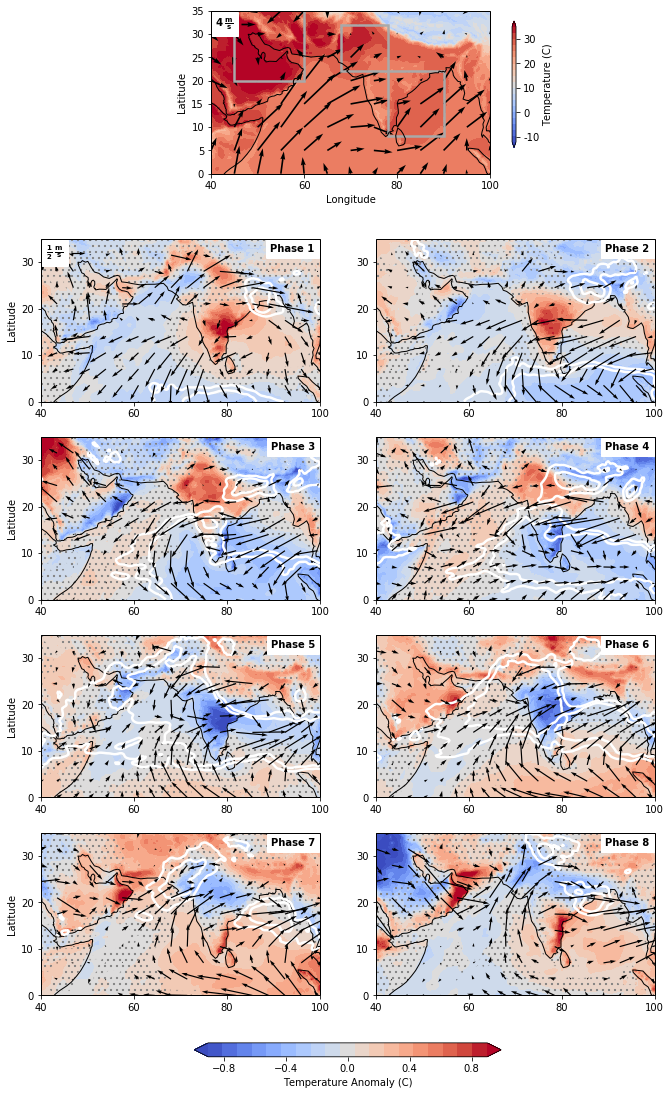

In [13]:
# Plot regional climatology
n = 20
skip = (slice(None, None, n), slice(None, None, n))

fig, axs = plt.subplots(5,2, figsize=(11,22), facecolor='w', edgecolor='k', subplot_kw = {'projection': ccrs.PlateCarree()})
sub_axs = axs[1:5,:].ravel()

clim_levels = np.linspace(-12,35, 20)

temp_map = axs[0,0].contourf(temp_clim.longitude, temp_clim.latitude, temp_clim.t2m, levels = clim_levels, cmap = 'coolwarm',  extend = 'both')
winds = axs[0,0].quiver(uwind_clim.longitude[::n], uwind_clim.latitude[::n], uwind_clim.u10[skip], vwind_clim.v10[skip])
qk = axs[0,0].quiverkey(winds, 0.108, 0.92, 4, r'$\mathbf{4 \: \frac{m}{s}}$',labelpos='W', coordinates='axes', color='k', labelcolor='k', fontproperties = {"weight": "bold"})
box = qk.text.set_backgroundcolor('w')

axs[0,0].set_ylabel('Latitude')
axs[0,0].set_xlabel('Longitude')
axs[0,0].coastlines(resolution = '110m')
axs[0,0].set_xticks([40, 60, 80, 100], crs=ccrs.PlateCarree())
axs[0,0].set_yticks([0, 5, 10, 15, 20, 25, 30, 35], crs=ccrs.PlateCarree())

# Add boxes for subregions
p1 = plt.Rectangle((CME_lon[0], CME_lat[0]), CME_lon[1]-CME_lon[0], CME_lat[1]-CME_lat[0], fill=False, linewidth = 2.5, color = 'darkgrey')
p2 = plt.Rectangle((NW_lon[0], NW_lat[0]), NW_lon[1]-NW_lon[0], NW_lat[1]-NW_lat[0], fill=False, linewidth = 2.5, color = 'darkgrey')
p3 = plt.Rectangle((SE_lon[0], SE_lat[0]), SE_lon[1]-SE_lon[0], SE_lat[1]-SE_lat[0], fill=False, linewidth = 2.5, color = 'darkgrey')
axs[0,0].add_patch(p1)
axs[0,0].add_patch(p2)
axs[0,0].add_patch(p3)

cax = fig.add_axes([0.72, 0.78, 0.005, 0.08])
colorb = fig.colorbar(temp_map, cax = cax, shrink = 0.5, format = "%d", label = 'Temperature (C)')
tick_locator = ticker.MaxNLocator(nbins=5)
colorb.locator = tick_locator
colorb.update_ticks()

fig.delaxes(axs[0,1])

# Move subplot 1 and colorbar to center
box = axs[0,0].get_position()
box.x0 = box.x0 + 0.215
box.x1 = box.x1 + 0.215
axs[0,0].set_position(box)

# Plot regional maps of temperature anomalies

# MJJA
n = 14
skip = (slice(None, None, n), slice(None, None, n))

levels = np.linspace(-0.9,0.9, 20)
clevels = np.arange(-8, 0, 4)
plt.rcParams['contour.negative_linestyle'] = 'solid'

x = temp.longitude
y = temp.latitude

plt.rcParams.update({'hatch.color': 'grey'})

for i in range(8):
    
    sig_mask = genfromtxt("JA_T_phase" + np.str(i+1) + "_sigmask.csv", delimiter=',').astype(np.bool)

    unsig = ~np.array(sig_mask)
    unsig_plot = unsig.astype(int)

    [m,n] = np.where(unsig_plot > 0)

    z1=np.zeros(unsig_plot.shape)
    z1[m, n] = 99
    
    u = uwind.sel(OMIphase = i+1)
    u1 = u.u10

    v = vwind.sel(OMIphase = i+1)
    v1 = v.v10

    #lat = u1.latitude
    #lon = v1.longitude
    
    #lat_sub = lat[::n]
    #lon_sub = lon[::n]

    u_sub = u1[skip]
    v_sub = v1[skip]
    
    contf = sub_axs[i].contourf(temp.sel(OMIphase = i+1).longitude, temp.sel(OMIphase = i+1).latitude, 
                           temp.sel(OMIphase = i+1).t2m, levels = levels, cmap = 'coolwarm', extend = 'both', zorder = 1)
    cont = sub_axs[i].contour(OLR.sel(OMIphase = i+1).longitude, OLR.sel(OMIphase = i+1).latitude, OLR.sel(OMIphase = i+1).mtnlwrf, clevels, colors ='white', extend='both', linewidths = 2.5, zorder = 2)
    q = sub_axs[i].quiver(uwind_clim.longitude[::14], uwind_clim.latitude[::14], u_sub, v_sub, zorder = 3)
    sub_axs[i].coastlines()
    phase_label = sub_axs[i].text(0.982,0.92,'Phase ' + str(i+1), horizontalalignment = 'right',transform = sub_axs[i].transAxes, fontweight = 600)
    phase_label.set_bbox(dict(facecolor='white', edgecolor = 'white'))
    sub_axs[i].set_yticks([0, 10, 20, 30], crs=ccrs.PlateCarree())
    sub_axs[i].set_xticks([40, 60, 80, 100], crs=ccrs.PlateCarree())
    
    cs = sub_axs[i].contourf(x, y, z1, 3, hatches=['', '..'], colors = 'grey',linestyles = None, alpha = 0)
    
    if (i % 2) == 0:
        sub_axs[i].set_ylabel('Latitude')  
    
    if (i == 8) or (i == 9):
        sub_axs[i].set_xlabel('Longitude')
        
    if i == 0:
        qk = sub_axs[0].quiverkey(q, 0.108, 0.915, 0.5, r'$\mathbf{\frac{1}{2} \: \frac{m}{s}}$',labelpos='W', coordinates='axes', color='k', labelcolor='k', fontproperties = {"weight": 600})
        box = qk.text.set_backgroundcolor('w')
        
cbar = plt.colorbar(contf, ax=sub_axs.ravel().tolist(), shrink = 0.5, location = 'bottom', pad = 0.05)
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label('Temperature Anomaly (C)')
plt.show()

## Specific Humidity

### MAY-JUNE

In [36]:
# Load data
SH = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_SH.nc')
SH_clim = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_SH_clim.nc')

uwind = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_uwind.nc')
vwind = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_vwind.nc')
uwind_clim = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_uwind_clim.nc')
vwind_clim = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_vwind_clim.nc')

OLR = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_OLR.nc')

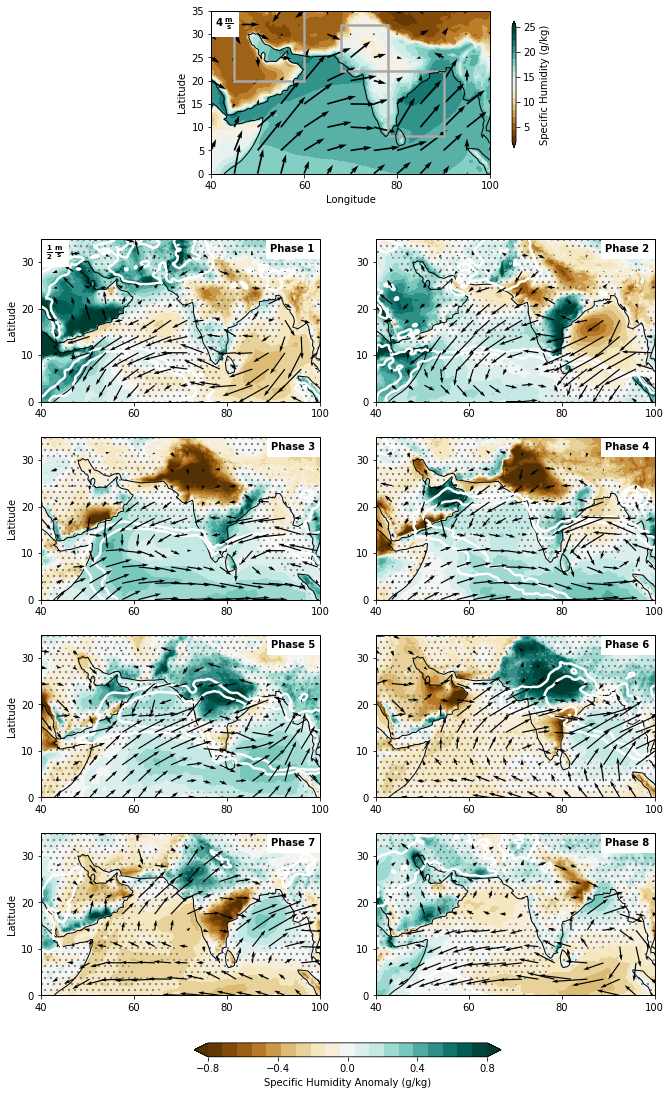

In [58]:
# Plot regional climatology
n = 20
skip = (slice(None, None, n), slice(None, None, n))

fig, axs = plt.subplots(5,2, figsize=(11,22), facecolor='w', edgecolor='k', subplot_kw = {'projection': ccrs.PlateCarree()})
sub_axs = axs[1:5,:].ravel()

clim_levels = np.linspace(2, 25, 19)

SH_map = axs[0,0].contourf(SH_clim.longitude, SH_clim.latitude, 1000*SH_clim.q, levels = clim_levels, cmap = 'BrBG',  extend = 'both')
winds = axs[0,0].quiver(uwind_clim.longitude[::n], uwind_clim.latitude[::n], uwind_clim.u10[skip], vwind_clim.v10[skip])
qk = axs[0,0].quiverkey(winds, 0.108, 0.92, 4, r'$\mathbf{4 \: \frac{m}{s}}$',labelpos='W', coordinates='axes', color='k', labelcolor='k', fontproperties = {"weight": "bold"})
box = qk.text.set_backgroundcolor('w')

axs[0,0].set_ylabel('Latitude')
axs[0,0].set_xlabel('Longitude')
axs[0,0].coastlines(resolution = '110m')
axs[0,0].set_xticks([40, 60, 80, 100], crs=ccrs.PlateCarree())
axs[0,0].set_yticks([0, 5, 10, 15, 20, 25, 30, 35], crs=ccrs.PlateCarree())

# Add boxes for subregions
p1 = plt.Rectangle((CME_lon[0], CME_lat[0]), CME_lon[1]-CME_lon[0], CME_lat[1]-CME_lat[0], fill=False, linewidth = 2.5, color = 'darkgrey')
p2 = plt.Rectangle((NW_lon[0], NW_lat[0]), NW_lon[1]-NW_lon[0], NW_lat[1]-NW_lat[0], fill=False, linewidth = 2.5, color = 'darkgrey')
p3 = plt.Rectangle((SE_lon[0], SE_lat[0]), SE_lon[1]-SE_lon[0], SE_lat[1]-SE_lat[0], fill=False, linewidth = 2.5, color = 'darkgrey')
axs[0,0].add_patch(p1)
axs[0,0].add_patch(p2)
axs[0,0].add_patch(p3)

cax = fig.add_axes([0.72, 0.78, 0.005, 0.08])
colorb = fig.colorbar(SH_map, cax = cax, shrink = 0.5, format = "%d", label = 'Specific Humidity (g/kg)')
tick_locator = ticker.MaxNLocator(nbins=5)
colorb.locator = tick_locator
colorb.update_ticks()

fig.delaxes(axs[0,1])

# Move subplot 1 and colorbar to center
box = axs[0,0].get_position()
box.x0 = box.x0 + 0.215
box.x1 = box.x1 + 0.215
axs[0,0].set_position(box)

# Plot regional maps of temperature anomalies

# MJJA
N = 14
skip = (slice(None, None, N), slice(None, None, N))

levels = np.linspace(-0.8, 0.8, 20)
clevels = np.arange(-8, 0, 4)
plt.rcParams['contour.negative_linestyle'] = 'solid'

x = SH.longitude
y = SH.latitude

plt.rcParams.update({'hatch.color': 'grey'})

for i in range(8):
    
    sig_mask = genfromtxt("MJ_q_phase" + np.str(i+1) + "_sigmask.csv", delimiter=',').astype(np.bool)

    unsig = ~np.array(sig_mask)
    unsig_plot = unsig.astype(int)

    [m,n] = np.where(unsig_plot > 0)

    z1=np.zeros(unsig_plot.shape)
    z1[m, n] = 99
    
    u = uwind.sel(OMIphase = i+1)
    u1 = u.u10

    v = vwind.sel(OMIphase = i+1)
    v1 = v.v10

    lat = u1.latitude
    lon = u1.longitude
    
    lat_sub = lat[::N]
    lon_sub = lon[::N]

    lon_mesh, lat_mesh = np.meshgrid(lon_sub, lat_sub)

    u_sub = u1[skip]
    v_sub = v1[skip]
    
    contf = sub_axs[i].contourf(SH.sel(OMIphase = i+1).longitude, SH.sel(OMIphase = i+1).latitude, 
                           1000*SH.sel(OMIphase = i+1).q, levels = levels, cmap = 'BrBG', extend = 'both', zorder = 1)
    cont = sub_axs[i].contour(OLR.sel(OMIphase = i+1).longitude, OLR.sel(OMIphase = i+1).latitude, OLR.sel(OMIphase = i+1).mtnlwrf, clevels, colors ='white', extend='both', linewidths = 2.5, zorder = 2)
    q = sub_axs[i].quiver(lon_sub, lat_sub, u_sub, v_sub, zorder = 3)
    sub_axs[i].coastlines()
    phase_label = sub_axs[i].text(0.982,0.92,'Phase ' + str(i+1), horizontalalignment = 'right',transform = sub_axs[i].transAxes, fontweight = 600)
    phase_label.set_bbox(dict(facecolor='white', edgecolor = 'white'))
    sub_axs[i].set_yticks([0, 10, 20, 30], crs=ccrs.PlateCarree())
    sub_axs[i].set_xticks([40, 60, 80, 100], crs=ccrs.PlateCarree())
    
    cs = sub_axs[i].contourf(x, y, z1, 3, hatches=['', '..'], colors = 'grey',linestyles = None, alpha = 0)
    
    if (i % 2) == 0:
        sub_axs[i].set_ylabel('Latitude')  
    
    if (i == 8) or (i == 9):
        sub_axs[i].set_xlabel('Longitude')
        
    if i == 0:
        qk = sub_axs[0].quiverkey(q, 0.108, 0.915, 0.5, r'$\mathbf{\frac{1}{2} \: \frac{m}{s}}$',labelpos='W', coordinates='axes', color='k', labelcolor='k', fontproperties = {"weight": 600})
        box = qk.text.set_backgroundcolor('w')
        
cbar = plt.colorbar(contf, ax=sub_axs.ravel().tolist(), shrink = 0.5, location = 'bottom', pad = 0.05)
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label('Specific Humidity Anomaly (g/kg)')
plt.show()

### JULY-AUGUST

In [14]:
# Load data
SH = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_SH.nc')
SH_clim = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_SH_clim.nc')

uwind = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_uwind.nc')
vwind = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_vwind.nc')
uwind_clim = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_uwind_clim.nc')
vwind_clim = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_vwind_clim.nc')

OLR = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_OLR.nc')

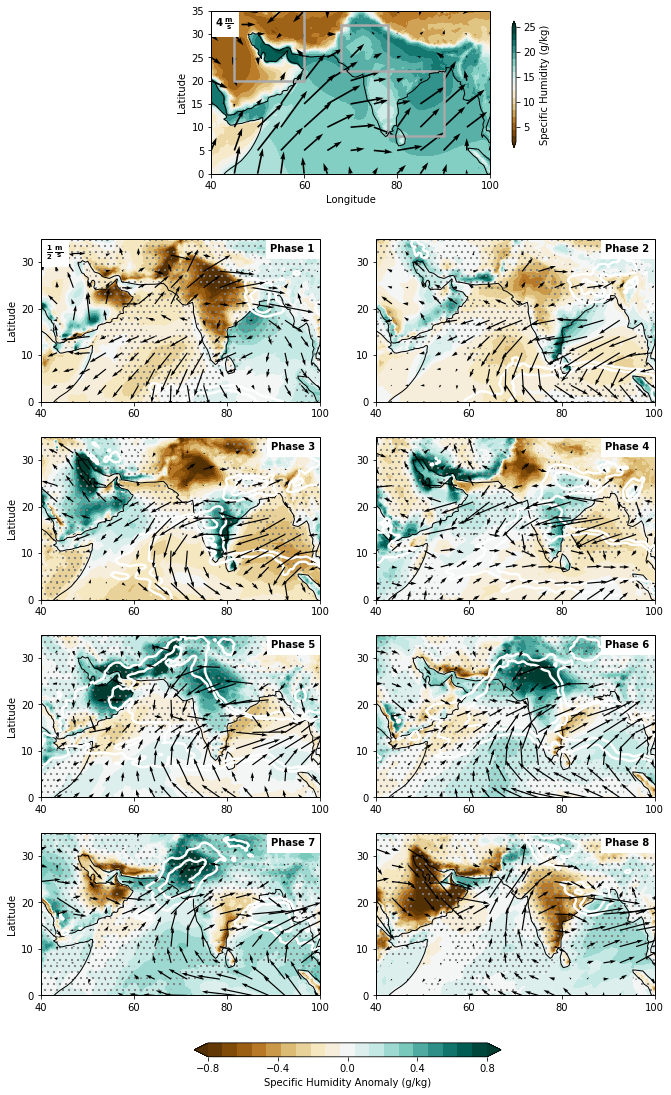

In [15]:
# Plot regional climatology
n = 20
skip = (slice(None, None, n), slice(None, None, n))

fig, axs = plt.subplots(5,2, figsize=(11,22), facecolor='w', edgecolor='k', subplot_kw = {'projection': ccrs.PlateCarree()})
sub_axs = axs[1:5,:].ravel()

clim_levels = np.linspace(2, 25, 19)

SH_map = axs[0,0].contourf(SH_clim.longitude, SH_clim.latitude, 1000*SH_clim.q, levels = clim_levels, cmap = 'BrBG',  extend = 'both')
winds = axs[0,0].quiver(uwind_clim.longitude[::n], uwind_clim.latitude[::n], uwind_clim.u10[skip], vwind_clim.v10[skip])
qk = axs[0,0].quiverkey(winds, 0.108, 0.92, 4, r'$\mathbf{4 \: \frac{m}{s}}$',labelpos='W', coordinates='axes', color='k', labelcolor='k', fontproperties = {"weight": "bold"})
box = qk.text.set_backgroundcolor('w')

axs[0,0].set_ylabel('Latitude')
axs[0,0].set_xlabel('Longitude')
axs[0,0].coastlines(resolution = '110m')
axs[0,0].set_xticks([40, 60, 80, 100], crs=ccrs.PlateCarree())
axs[0,0].set_yticks([0, 5, 10, 15, 20, 25, 30, 35], crs=ccrs.PlateCarree())

# Add boxes for subregions
p1 = plt.Rectangle((CME_lon[0], CME_lat[0]), CME_lon[1]-CME_lon[0], CME_lat[1]-CME_lat[0], fill=False, linewidth = 2.5, color = 'darkgrey')
p2 = plt.Rectangle((NW_lon[0], NW_lat[0]), NW_lon[1]-NW_lon[0], NW_lat[1]-NW_lat[0], fill=False, linewidth = 2.5, color = 'darkgrey')
p3 = plt.Rectangle((SE_lon[0], SE_lat[0]), SE_lon[1]-SE_lon[0], SE_lat[1]-SE_lat[0], fill=False, linewidth = 2.5, color = 'darkgrey')
axs[0,0].add_patch(p1)
axs[0,0].add_patch(p2)
axs[0,0].add_patch(p3)

cax = fig.add_axes([0.72, 0.78, 0.005, 0.08])
colorb = fig.colorbar(SH_map, cax = cax, shrink = 0.5, format = "%d", label = 'Specific Humidity (g/kg)')
tick_locator = ticker.MaxNLocator(nbins=5)
colorb.locator = tick_locator
colorb.update_ticks()

fig.delaxes(axs[0,1])

# Move subplot 1 and colorbar to center
box = axs[0,0].get_position()
box.x0 = box.x0 + 0.215
box.x1 = box.x1 + 0.215
axs[0,0].set_position(box)

# Plot regional maps of temperature anomalies

# MJJA
N = 14
skip = (slice(None, None, N), slice(None, None, N))

levels = np.linspace(-0.8, 0.8, 20)
clevels = np.arange(-8, 0, 4)
plt.rcParams['contour.negative_linestyle'] = 'solid'

x = SH.longitude
y = SH.latitude

plt.rcParams.update({'hatch.color': 'grey'})

for i in range(8):
    
    sig_mask = genfromtxt("MJ_q_phase" + np.str(i+1) + "_sigmask.csv", delimiter=',').astype(np.bool)

    unsig = ~np.array(sig_mask)
    unsig_plot = unsig.astype(int)

    [m,n] = np.where(unsig_plot > 0)

    z1=np.zeros(unsig_plot.shape)
    z1[m, n] = 99
    
    u = uwind.sel(OMIphase = i+1)
    u1 = u.u10

    v = vwind.sel(OMIphase = i+1)
    v1 = v.v10

    lat = u1.latitude
    lon = u1.longitude
    
    lat_sub = lat[::N]
    lon_sub = lon[::N]

    lon_mesh, lat_mesh = np.meshgrid(lon_sub, lat_sub)

    u_sub = u1[skip]
    v_sub = v1[skip]
    
    contf = sub_axs[i].contourf(SH.sel(OMIphase = i+1).longitude, SH.sel(OMIphase = i+1).latitude, 
                           1000*SH.sel(OMIphase = i+1).q, levels = levels, cmap = 'BrBG', extend = 'both', zorder = 1)
    cont = sub_axs[i].contour(OLR.sel(OMIphase = i+1).longitude, OLR.sel(OMIphase = i+1).latitude, OLR.sel(OMIphase = i+1).mtnlwrf, clevels, colors ='white', extend='both', linewidths = 2.5, zorder = 2)
    q = sub_axs[i].quiver(lon_sub, lat_sub, u_sub, v_sub, zorder = 3)
    sub_axs[i].coastlines()
    phase_label = sub_axs[i].text(0.982,0.92,'Phase ' + str(i+1), horizontalalignment = 'right',transform = sub_axs[i].transAxes, fontweight = 600)
    phase_label.set_bbox(dict(facecolor='white', edgecolor = 'white'))
    sub_axs[i].set_yticks([0, 10, 20, 30], crs=ccrs.PlateCarree())
    sub_axs[i].set_xticks([40, 60, 80, 100], crs=ccrs.PlateCarree())
    
    cs = sub_axs[i].contourf(x, y, z1, 3, hatches=['', '..'], colors = 'grey',linestyles = None, alpha = 0)
    
    if (i % 2) == 0:
        sub_axs[i].set_ylabel('Latitude')  
    
    if (i == 8) or (i == 9):
        sub_axs[i].set_xlabel('Longitude')
        
    if i == 0:
        qk = sub_axs[0].quiverkey(q, 0.108, 0.915, 0.5, r'$\mathbf{\frac{1}{2} \: \frac{m}{s}}$',labelpos='W', coordinates='axes', color='k', labelcolor='k', fontproperties = {"weight": 600})
        box = qk.text.set_backgroundcolor('w')
        
cbar = plt.colorbar(contf, ax=sub_axs.ravel().tolist(), shrink = 0.5, location = 'bottom', pad = 0.05)
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label('Specific Humidity Anomaly (g/kg)')
plt.show()

## Wet Bulb

### MAY-JUNE

In [5]:
# Load data
TW = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_TW.nc')
TW_clim = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_TW_clim.nc')

OLR = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_OLR.nc')

# Load data
uwind = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_uwind.nc')
vwind = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_vwind.nc')

uwind_clim = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_uwind_clim.nc')
vwind_clim = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_vwind_clim.nc')

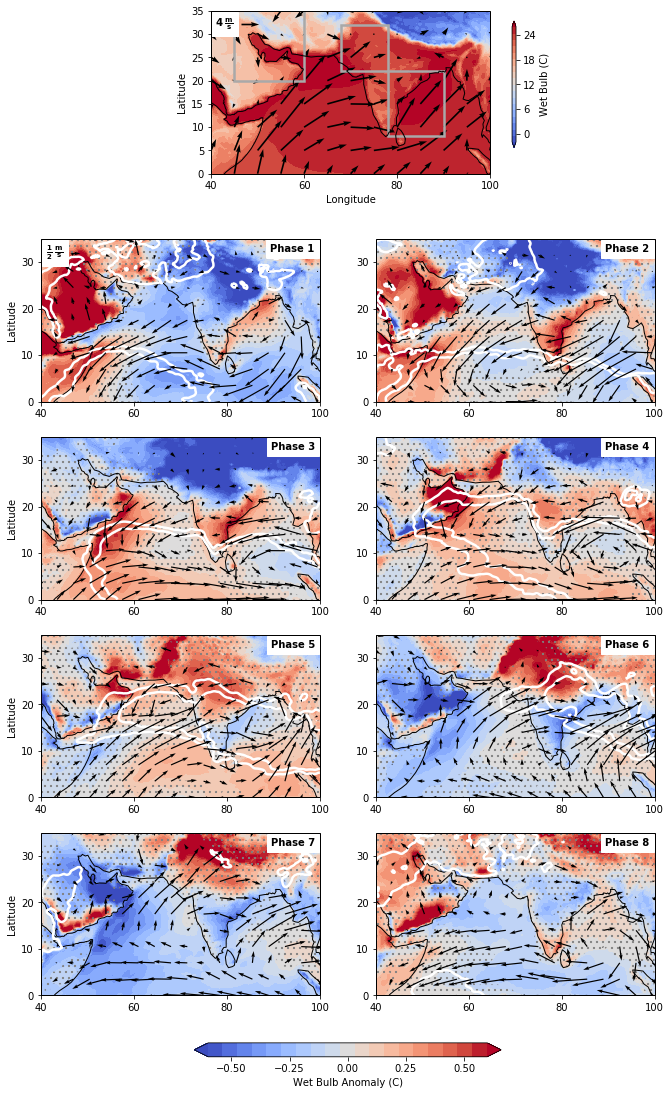

In [62]:
# Plot regional climatology
n = 20
skip = (slice(None, None, n), slice(None, None, n))

fig, axs = plt.subplots(5,2, figsize=(11,22), facecolor='w', edgecolor='k', subplot_kw = {'projection': ccrs.PlateCarree()})
sub_axs = axs[1:5,:].ravel()

clim_levels = np.linspace(-2, 26, 19)

TW_map = axs[0,0].contourf(TW_clim.longitude, TW_clim.latitude, TW_clim.Tw, levels = clim_levels, cmap = 'coolwarm',  extend = 'both')
winds = axs[0,0].quiver(uwind_clim.longitude[::n], uwind_clim.latitude[::n], uwind_clim.u10[skip], vwind_clim.v10[skip])
qk = axs[0,0].quiverkey(winds, 0.108, 0.92, 4, r'$\mathbf{4 \: \frac{m}{s}}$',labelpos='W', coordinates='axes', color='k', labelcolor='k', fontproperties = {"weight": "bold"})
box = qk.text.set_backgroundcolor('w')

axs[0,0].set_ylabel('Latitude')
axs[0,0].set_xlabel('Longitude')
axs[0,0].coastlines(resolution = '110m')
axs[0,0].set_xticks([40, 60, 80, 100], crs=ccrs.PlateCarree())
axs[0,0].set_yticks([0, 5, 10, 15, 20, 25, 30, 35], crs=ccrs.PlateCarree())

# Add boxes for subregions
p1 = plt.Rectangle((CME_lon[0], CME_lat[0]), CME_lon[1]-CME_lon[0], CME_lat[1]-CME_lat[0], fill=False, linewidth = 2.5, color = 'darkgrey')
p2 = plt.Rectangle((NW_lon[0], NW_lat[0]), NW_lon[1]-NW_lon[0], NW_lat[1]-NW_lat[0], fill=False, linewidth = 2.5, color = 'darkgrey')
p3 = plt.Rectangle((SE_lon[0], SE_lat[0]), SE_lon[1]-SE_lon[0], SE_lat[1]-SE_lat[0], fill=False, linewidth = 2.5, color = 'darkgrey')
axs[0,0].add_patch(p1)
axs[0,0].add_patch(p2)
axs[0,0].add_patch(p3)

cax = fig.add_axes([0.72, 0.78, 0.005, 0.08])
colorb = fig.colorbar(TW_map, cax = cax, shrink = 0.5, format = "%d", label = 'Wet Bulb (C)')
tick_locator = ticker.MaxNLocator(nbins=5)
colorb.locator = tick_locator
colorb.update_ticks()

fig.delaxes(axs[0,1])

# Move subplot 1 and colorbar to center
box = axs[0,0].get_position()
box.x0 = box.x0 + 0.215
box.x1 = box.x1 + 0.215
axs[0,0].set_position(box)

x = TW.longitude
y = TW.latitude

plt.rcParams.update({'hatch.color': 'grey'})

# Plot regional maps of temperature anomalies

# MJJA
N = 14
skip = (slice(None, None, N), slice(None, None, N))

levels = np.linspace(-0.6, 0.6, 20)
clevels = np.arange(-8, 0, 4)
plt.rcParams['contour.negative_linestyle'] = 'solid'

for i in range(8):
    
    sig_mask = genfromtxt("MJ_TW_phase" + np.str(i+1) + "_sigmask.csv", delimiter=',').astype(np.bool)

    unsig = ~np.array(sig_mask)
    unsig_plot = unsig.astype(int)

    [m,n] = np.where(unsig_plot > 0)

    z1=np.zeros(unsig_plot.shape)
    z1[m, n] = 99
    
    u = uwind.sel(OMIphase = i+1)
    u1 = u.u10

    v = vwind.sel(OMIphase = i+1)
    v1 = v.v10

    lat = u1.latitude
    lon = u1.longitude
    
    lat_sub = lat[::N]
    lon_sub = lon[::N]

    lon_mesh, lat_mesh = np.meshgrid(lon_sub, lat_sub)

    u_sub = u1[skip]
    v_sub = v1[skip]
    
    contf = sub_axs[i].contourf(TW.sel(OMIphase = i+1).longitude, TW.sel(OMIphase = i+1).latitude, 
                           TW.sel(OMIphase = i+1).Tw, levels = levels, cmap = 'coolwarm', extend = 'both', zorder = 1)
    cont = sub_axs[i].contour(OLR.sel(OMIphase = i+1).longitude, OLR.sel(OMIphase = i+1).latitude, OLR.sel(OMIphase = i+1).mtnlwrf, clevels, colors ='white', extend='both', linewidths = 2.5, zorder = 2)
    q = sub_axs[i].quiver(lon_sub, lat_sub, u_sub, v_sub, zorder = 3)
    sub_axs[i].coastlines()
    phase_label = sub_axs[i].text(0.982,0.92,'Phase ' + str(i+1), horizontalalignment = 'right',transform = sub_axs[i].transAxes, fontweight = 600)
    phase_label.set_bbox(dict(facecolor='white', edgecolor = 'white'))
    sub_axs[i].set_yticks([0, 10, 20, 30], crs=ccrs.PlateCarree())
    sub_axs[i].set_xticks([40, 60, 80, 100], crs=ccrs.PlateCarree())
    
    cs = sub_axs[i].contourf(x, y, z1, 3, hatches=['', '..'], colors = 'grey',linestyles = None, alpha = 0)
    
    if (i % 2) == 0:
        sub_axs[i].set_ylabel('Latitude')  
    
    if (i == 8) or (i == 9):
        sub_axs[i].set_xlabel('Longitude')
        
    if i == 0:
        qk = sub_axs[0].quiverkey(q, 0.108, 0.915, 0.5, r'$\mathbf{\frac{1}{2} \: \frac{m}{s}}$',labelpos='W', coordinates='axes', color='k', labelcolor='k', fontproperties = {"weight": 600})
        box = qk.text.set_backgroundcolor('w')
        
cbar = plt.colorbar(contf, ax=sub_axs.ravel().tolist(), shrink = 0.5, location = 'bottom', pad = 0.05)
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label('Wet Bulb Anomaly (C)')
plt.show()

### JULY-AUGUST

In [63]:
# Load data
TW = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_TW.nc')
TW_clim = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_TW_clim.nc')

OLR = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_OLR.nc')

# Load data
uwind = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_uwind.nc')
vwind = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_vwind.nc')

uwind_clim = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_uwind_clim.nc')
vwind_clim = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_vwind_clim.nc')

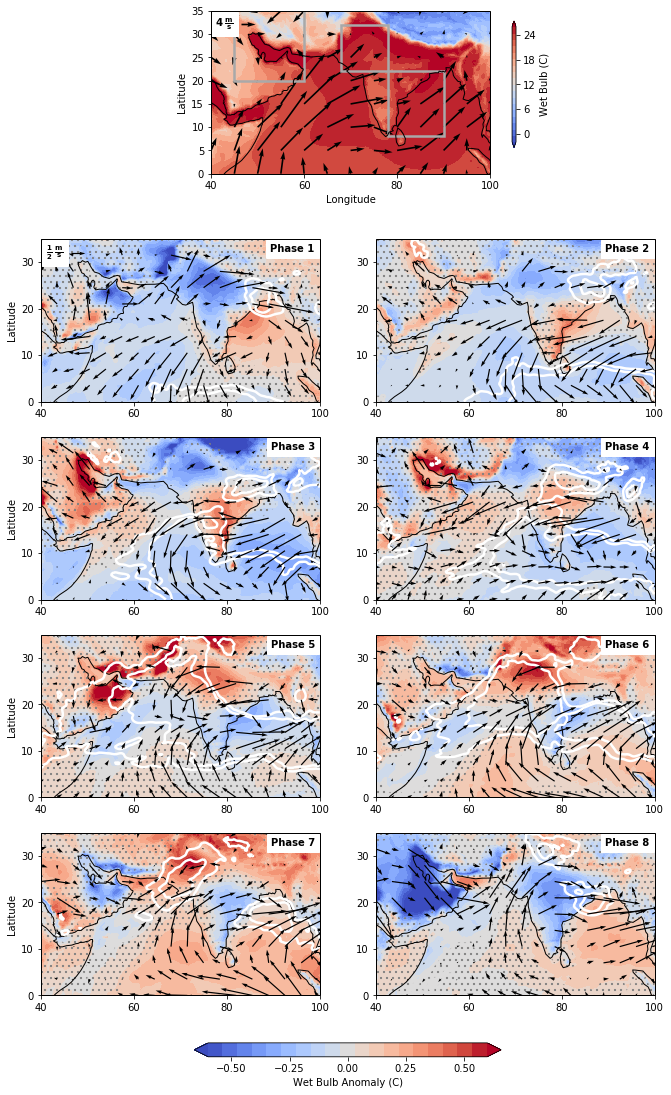

In [64]:
# Plot regional climatology
n = 20
skip = (slice(None, None, n), slice(None, None, n))

fig, axs = plt.subplots(5,2, figsize=(11,22), facecolor='w', edgecolor='k', subplot_kw = {'projection': ccrs.PlateCarree()})
sub_axs = axs[1:5,:].ravel()

clim_levels = np.linspace(-2, 26, 19)

TW_map = axs[0,0].contourf(TW_clim.longitude, TW_clim.latitude, TW_clim.Tw, levels = clim_levels, cmap = 'coolwarm',  extend = 'both')
winds = axs[0,0].quiver(uwind_clim.longitude[::n], uwind_clim.latitude[::n], uwind_clim.u10[skip], vwind_clim.v10[skip])
qk = axs[0,0].quiverkey(winds, 0.108, 0.92, 4, r'$\mathbf{4 \: \frac{m}{s}}$',labelpos='W', coordinates='axes', color='k', labelcolor='k', fontproperties = {"weight": "bold"})
box = qk.text.set_backgroundcolor('w')

axs[0,0].set_ylabel('Latitude')
axs[0,0].set_xlabel('Longitude')
axs[0,0].coastlines(resolution = '110m')
axs[0,0].set_xticks([40, 60, 80, 100], crs=ccrs.PlateCarree())
axs[0,0].set_yticks([0, 5, 10, 15, 20, 25, 30, 35], crs=ccrs.PlateCarree())

# Add boxes for subregions
p1 = plt.Rectangle((CME_lon[0], CME_lat[0]), CME_lon[1]-CME_lon[0], CME_lat[1]-CME_lat[0], fill=False, linewidth = 2.5, color = 'darkgrey')
p2 = plt.Rectangle((NW_lon[0], NW_lat[0]), NW_lon[1]-NW_lon[0], NW_lat[1]-NW_lat[0], fill=False, linewidth = 2.5, color = 'darkgrey')
p3 = plt.Rectangle((SE_lon[0], SE_lat[0]), SE_lon[1]-SE_lon[0], SE_lat[1]-SE_lat[0], fill=False, linewidth = 2.5, color = 'darkgrey')
axs[0,0].add_patch(p1)
axs[0,0].add_patch(p2)
axs[0,0].add_patch(p3)


cax = fig.add_axes([0.72, 0.78, 0.005, 0.08])
colorb = fig.colorbar(TW_map, cax = cax, shrink = 0.5, format = "%d", label = 'Wet Bulb (C)')
tick_locator = ticker.MaxNLocator(nbins=5)
colorb.locator = tick_locator
colorb.update_ticks()

fig.delaxes(axs[0,1])

# Move subplot 1 and colorbar to center
box = axs[0,0].get_position()
box.x0 = box.x0 + 0.215
box.x1 = box.x1 + 0.215
axs[0,0].set_position(box)

x = TW.longitude
y = TW.latitude

plt.rcParams.update({'hatch.color': 'grey'})

# Plot regional maps of temperature anomalies

# MJJA
N = 14
skip = (slice(None, None, N), slice(None, None, N))

levels = np.linspace(-0.6, 0.6, 20)
clevels = np.arange(-8, 0, 4)
plt.rcParams['contour.negative_linestyle'] = 'solid'

for i in range(8):
    
    sig_mask = genfromtxt("JA_TW_phase" + np.str(i+1) + "_sigmask.csv", delimiter=',').astype(np.bool)

    unsig = ~np.array(sig_mask)
    unsig_plot = unsig.astype(int)

    [m,n] = np.where(unsig_plot > 0)

    z1=np.zeros(unsig_plot.shape)
    z1[m, n] = 99
    
    u = uwind.sel(OMIphase = i+1)
    u1 = u.u10

    v = vwind.sel(OMIphase = i+1)
    v1 = v.v10

    lat = u1.latitude
    lon = u1.longitude
    
    lat_sub = lat[::N]
    lon_sub = lon[::N]

    lon_mesh, lat_mesh = np.meshgrid(lon_sub, lat_sub)

    u_sub = u1[skip]
    v_sub = v1[skip]
    
    contf = sub_axs[i].contourf(TW.sel(OMIphase = i+1).longitude, TW.sel(OMIphase = i+1).latitude, 
                           TW.sel(OMIphase = i+1).Tw, levels = levels, cmap = 'coolwarm', extend = 'both', zorder = 1)
    cont = sub_axs[i].contour(OLR.sel(OMIphase = i+1).longitude, OLR.sel(OMIphase = i+1).latitude, OLR.sel(OMIphase = i+1).mtnlwrf, clevels, colors ='white', extend='both', linewidths = 2.5, zorder = 2)
    q = sub_axs[i].quiver(lon_sub, lat_sub, u_sub, v_sub, zorder = 3)
    sub_axs[i].coastlines()
    phase_label = sub_axs[i].text(0.982,0.92,'Phase ' + str(i+1), horizontalalignment = 'right',transform = sub_axs[i].transAxes, fontweight = 600)
    phase_label.set_bbox(dict(facecolor='white', edgecolor = 'white'))
    sub_axs[i].set_yticks([0, 10, 20, 30], crs=ccrs.PlateCarree())
    sub_axs[i].set_xticks([40, 60, 80, 100], crs=ccrs.PlateCarree())
    
    cs = sub_axs[i].contourf(x, y, z1, 3, hatches=['', '..'], colors = 'grey',linestyles = None, alpha = 0)
    
    if (i % 2) == 0:
        sub_axs[i].set_ylabel('Latitude')  
    
    if (i == 8) or (i == 9):
        sub_axs[i].set_xlabel('Longitude')
        
    if i == 0:
        qk = sub_axs[0].quiverkey(q, 0.108, 0.915, 0.5, r'$\mathbf{\frac{1}{2} \: \frac{m}{s}}$',labelpos='W', coordinates='axes', color='k', labelcolor='k', fontproperties = {"weight": 600})
        box = qk.text.set_backgroundcolor('w')
        
cbar = plt.colorbar(contf, ax=sub_axs.ravel().tolist(), shrink = 0.5, location = 'bottom', pad = 0.05)
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label('Wet Bulb Anomaly (C)')
plt.show()

## Specific Humidity with Water Vapor Flux

### MAY-JUNE

In [5]:
# Load data
SH = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_SH.nc')
SH_clim = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_SH_clim.nc')

OLR = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_OLR.nc')

evapor = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_evapor.nc')
nvapor = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_nvapor.nc')

evapor_clim = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_evapor_clim.nc')
nvapor_clim = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/MJ_regional_nvapor_clim.nc')

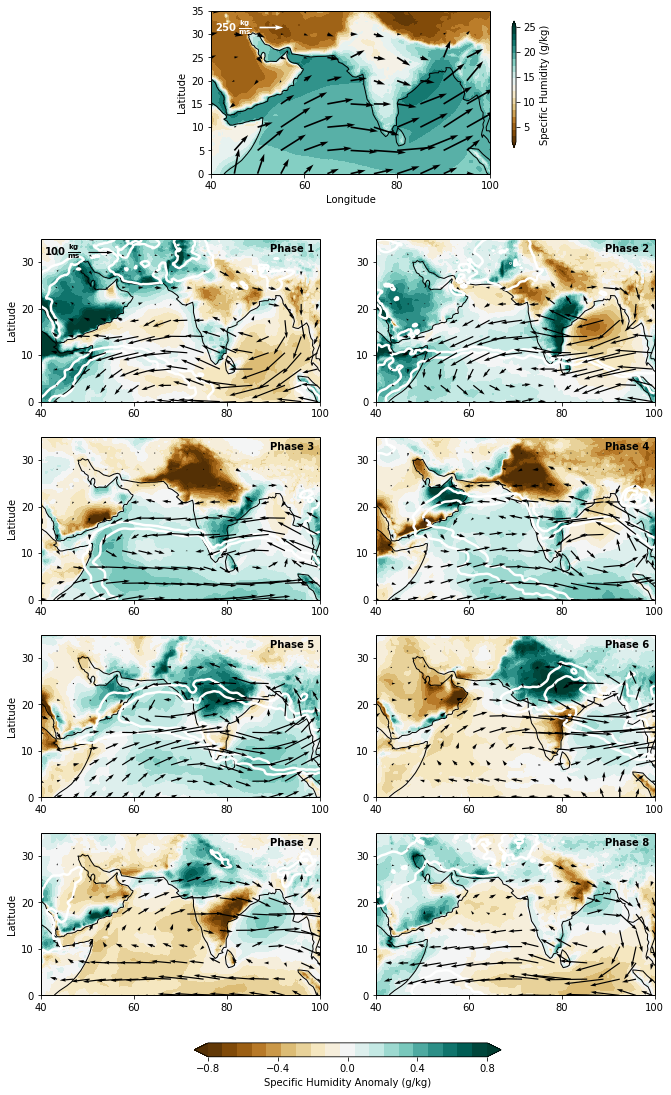

In [53]:
# Plot regional climatology
n = 20
skip = (slice(None, None, n), slice(None, None, n))

fig, axs = plt.subplots(5,2, figsize=(11,22), facecolor='w', edgecolor='k', subplot_kw = {'projection': ccrs.PlateCarree()})
sub_axs = axs[1:5,:].ravel()

clim_levels = np.linspace(2, 25, 19)

SH_map = axs[0,0].contourf(SH_clim.longitude, SH_clim.latitude, 1000*SH_clim.q, levels = clim_levels, cmap = 'BrBG',  extend = 'both')
flux = axs[0,0].quiver(evapor_clim.longitude[::n], evapor_clim.latitude[::n], evapor_clim.e_vapor_flux[skip], nvapor_clim.n_vapor_flux[skip])
qk = axs[0,0].quiverkey(flux, 0.17, 0.9, 250, r'$\mathbf{250 \: \frac{kg}{m s}}$',labelpos='W', coordinates='axes', color='w', labelcolor='w', fontproperties = {"weight": "bold"})

axs[0,0].set_ylabel('Latitude')
axs[0,0].set_xlabel('Longitude')
axs[0,0].coastlines(resolution = '110m')
axs[0,0].set_xticks([40, 60, 80, 100], crs=ccrs.PlateCarree())
axs[0,0].set_yticks([0, 5, 10, 15, 20, 25, 30, 35], crs=ccrs.PlateCarree())

cax = fig.add_axes([0.72, 0.78, 0.005, 0.08])
colorb = fig.colorbar(SH_map, cax = cax, shrink = 0.5, format = "%d", label = 'Specific Humidity (g/kg)')
tick_locator = ticker.MaxNLocator(nbins=5)
colorb.locator = tick_locator
colorb.update_ticks()

fig.delaxes(axs[0,1])

# Move subplot 1 and colorbar to center
box = axs[0,0].get_position()
box.x0 = box.x0 + 0.215
box.x1 = box.x1 + 0.215
axs[0,0].set_position(box)

# Plot regional maps of temperature anomalies

# MJ
n = 14
skip = (slice(None, None, n), slice(None, None, n))

levels = np.linspace(-0.8, 0.8, 20)
clevels = np.arange(-8, 0, 4)
plt.rcParams['contour.negative_linestyle'] = 'solid'

for i in range(8):
    e = evapor.sel(OMIphase = i+1)
    e1 = e.e_vapor_flux

    n = nvapor.sel(OMIphase = i+1)
    n1 = n.n_vapor_flux

    lat = e1.latitude
    lon = e1.longitude
    
    lat_sub = lat[::14]
    lon_sub = lon[::14]

    e_sub = e1[skip]
    n_sub = n1[skip]
    
    contf = sub_axs[i].contourf(SH.sel(OMIphase = i+1).longitude, SH.sel(OMIphase = i+1).latitude, 
                           1000*SH.sel(OMIphase = i+1).q, levels = levels, cmap = 'BrBG', extend = 'both', zorder = 1)
    cont = sub_axs[i].contour(OLR.sel(OMIphase = i+1).longitude, OLR.sel(OMIphase = i+1).latitude, OLR.sel(OMIphase = i+1).mtnlwrf, clevels, colors ='white', extend='both', linewidths = 2.5, zorder = 2)
    q = sub_axs[i].quiver(lon_sub, lat_sub, e1[skip], n1[skip], zorder = 3)
    sub_axs[i].coastlines()
    sub_axs[i].text(0.98,0.92,'Phase ' + str(i+1), horizontalalignment = 'right',transform = sub_axs[i].transAxes, fontweight = 600)
    sub_axs[i].set_yticks([0, 10, 20, 30], crs=ccrs.PlateCarree())
    sub_axs[i].set_xticks([40, 60, 80, 100], crs=ccrs.PlateCarree())
    
    if (i % 2) == 0:
        sub_axs[i].set_ylabel('Latitude')  
    
    if (i == 8) or (i == 9):
        sub_axs[i].set_xlabel('Longitude')
        
    if i == 0:
        qk = sub_axs[0].quiverkey(q, 0.17, 0.92, 100, r'$\mathbf{100 \: \frac{kg}{m s}}$',labelpos='W', coordinates='axes', color='k', labelcolor='k', fontproperties = {"weight": 600})

cbar = plt.colorbar(contf, ax=sub_axs.ravel().tolist(), shrink = 0.5, location = 'bottom', pad = 0.05)
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label('Specific Humidity Anomaly (g/kg)')
plt.show()

### JULY-AUGUST

In [8]:
# Load data
SH = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_SH.nc')
SH_clim = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_SH_clim.nc')

OLR = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_OLR.nc')

evapor = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_evapor.nc')
nvapor = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_nvapor.nc')

evapor_clim = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_evapor_clim.nc')
nvapor_clim = xr.open_dataset('/dx01/ivanov/data/ERA5/MJO_TW/JA_regional_nvapor_clim.nc')

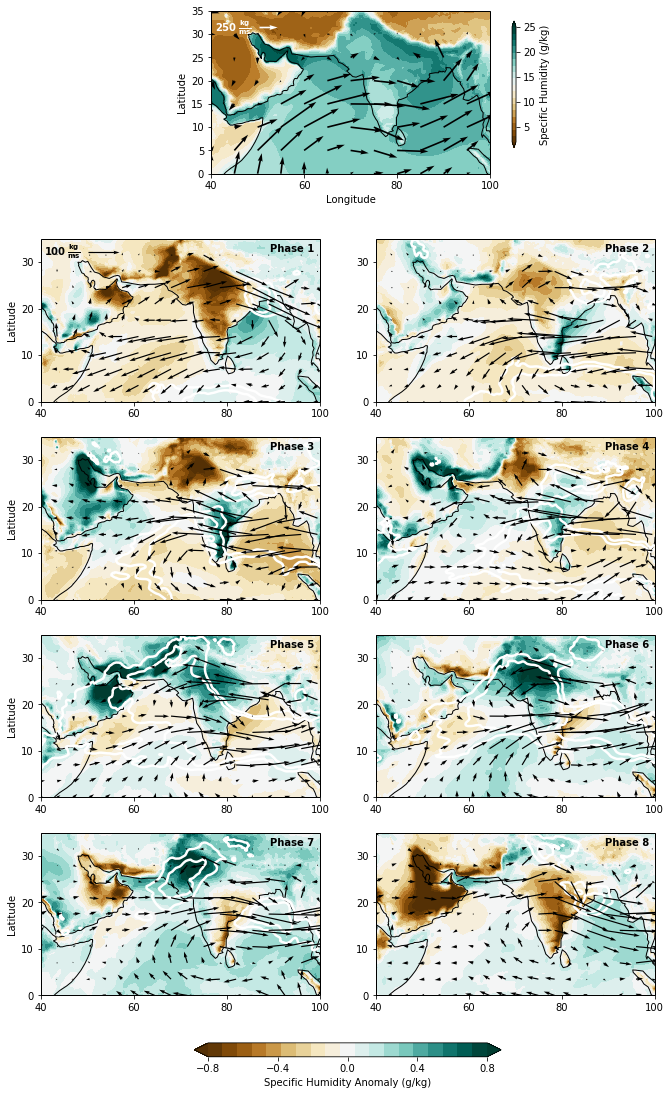

In [9]:
# Plot regional climatology
n = 20
skip = (slice(None, None, n), slice(None, None, n))

fig, axs = plt.subplots(5,2, figsize=(11,22), facecolor='w', edgecolor='k', subplot_kw = {'projection': ccrs.PlateCarree()})
sub_axs = axs[1:5,:].ravel()

clim_levels = np.linspace(2, 25, 19)

SH_map = axs[0,0].contourf(SH_clim.longitude, SH_clim.latitude, 1000*SH_clim.q, levels = clim_levels, cmap = 'BrBG',  extend = 'both')
flux = axs[0,0].quiver(evapor_clim.longitude[::n], evapor_clim.latitude[::n], evapor_clim.e_vapor_flux[skip], nvapor_clim.n_vapor_flux[skip])
qk = axs[0,0].quiverkey(flux, 0.17, 0.9, 250, r'$\mathbf{250 \: \frac{kg}{m s}}$',labelpos='W', coordinates='axes', color='w', labelcolor='w', fontproperties = {"weight": "bold"})

axs[0,0].set_ylabel('Latitude')
axs[0,0].set_xlabel('Longitude')
axs[0,0].coastlines(resolution = '110m')
axs[0,0].set_xticks([40, 60, 80, 100], crs=ccrs.PlateCarree())
axs[0,0].set_yticks([0, 5, 10, 15, 20, 25, 30, 35], crs=ccrs.PlateCarree())

cax = fig.add_axes([0.72, 0.78, 0.005, 0.08])
colorb = fig.colorbar(SH_map, cax = cax, shrink = 0.5, format = "%d", label = 'Specific Humidity (g/kg)')
tick_locator = ticker.MaxNLocator(nbins=5)
colorb.locator = tick_locator
colorb.update_ticks()

fig.delaxes(axs[0,1])

# Move subplot 1 and colorbar to center
box = axs[0,0].get_position()
box.x0 = box.x0 + 0.215
box.x1 = box.x1 + 0.215
axs[0,0].set_position(box)

# Plot regional maps of temperature anomalies

# MJ
n = int(14)
skip = (slice(None, None, n), slice(None, None, n))

levels = np.linspace(-0.8, 0.8, 20)
clevels = np.arange(-8, 0, 4)
plt.rcParams['contour.negative_linestyle'] = 'solid'

for i in range(8):
    e = evapor.sel(OMIphase = i+1)
    e1 = e.e_vapor_flux

    n = nvapor.sel(OMIphase = i+1)
    n1 = n.n_vapor_flux

    lat = e1.latitude
    lon = e1.longitude
    
    lat_sub = lat[::14]
    lon_sub = lon[::14]

    e_sub = e1[skip]
    n_sub = n1[skip]
    
    contf = sub_axs[i].contourf(SH.sel(OMIphase = i+1).longitude, SH.sel(OMIphase = i+1).latitude, 
                           1000*SH.sel(OMIphase = i+1).q, levels = levels, cmap = 'BrBG', extend = 'both', zorder = 1)
    cont = sub_axs[i].contour(OLR.sel(OMIphase = i+1).longitude, OLR.sel(OMIphase = i+1).latitude, OLR.sel(OMIphase = i+1).mtnlwrf, clevels, colors ='white', extend='both', linewidths = 2.5, zorder = 2)
    q = sub_axs[i].quiver(lon_sub, lat_sub, e1[skip], n1[skip], zorder = 3)
    sub_axs[i].coastlines()
    sub_axs[i].text(0.98,0.92,'Phase ' + str(i+1), horizontalalignment = 'right',transform = sub_axs[i].transAxes, fontweight = 600)
    sub_axs[i].set_yticks([0, 10, 20, 30], crs=ccrs.PlateCarree())
    sub_axs[i].set_xticks([40, 60, 80, 100], crs=ccrs.PlateCarree())
    
    if (i % 2) == 0:
        sub_axs[i].set_ylabel('Latitude')  
    
    if (i == 8) or (i == 9):
        sub_axs[i].set_xlabel('Longitude')
        
    if i == 0:
        qk = sub_axs[0].quiverkey(q, 0.17, 0.92, 100, r'$\mathbf{100 \: \frac{kg}{m s}}$',labelpos='W', coordinates='axes', color='k', labelcolor='k', fontproperties = {"weight": 600})

cbar = plt.colorbar(contf, ax=sub_axs.ravel().tolist(), shrink = 0.5, location = 'bottom', pad = 0.05)
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label('Specific Humidity Anomaly (g/kg)')
plt.show()